# Análisis de Calidad de Aire: Comportamiento entre Semana y Fines de Semana

## 1. Importar Librerías

El primer paso es importar las librerías necesarias:

- **pandas** y **numpy**: Para manejo y análisis de datos tabulares.
- **matplotlib** y **seaborn**: Para graficar y visualizar tendencias de PM2.5.
- **geopandas** y **shapely**: Para análisis y manipulación de información espacial.
- **esda** y **splot**: Para análisis estadístico espacial (como Moran Global y Local).
- **scipy.spatial**: Para generar diagramas de Voronoi (útil para mapas de influencia).

Se define también un estilo visual para las gráficas, haciendo que los resultados sean claros y profesionales.


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

from shapely.geometry import Point
from esda import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster
from scipy.spatial import Voronoi


## 2. Cargar y Preparar Datos

Se definen y cargan todos los archivos necesarios:

- **Archivos Shapefile:** Información geográfica del municipio, red vial, uso de suelo y comunas de Soacha, usados para análisis y mapas.
- **Excel:** Contiene las coordenadas (latitud y longitud) y el nombre de cada estación de monitoreo.
- **CSV:** Registra las mediciones horarias de PM2.5 y variables meteorológicas por estación.

### Detalles clave en el script:

- **Conversión de fechas:**  
  Se convierte la columna 'date' a tipo `datetime`, permitiendo extraer fácilmente la hora y el día, necesarios para el análisis temporal.
- **Homologación de nombres de columna:**  
  Se renombra 'station' a 'Estación' en el DataFrame de monitoreo, asegurando que el cruce con la tabla de coordenadas sea correcto.

Esto prepara la base para fusionar los datos espaciales y de monitoreo, y para los análisis por hora, día y estación.


In [6]:
# =============================================================================
# 2. Cargar y preparar datos
# =============================================================================

# Definir rutas a archivos de entrada
root_folder = "/notebooks/"
MON_path = root_folder + "data_MAR_1.csv"               # Datos de monitoreo
excel_path = root_folder + "Coordenadas_Instituciones.xlsx"  # Coordenadas de estaciones
SHAPE_MUN = root_folder + "municipios_colombia.shp"     # Shapefile municipios
SHAPE_REDVIAL = root_folder + "RedVial.shp"             # Red vial principal
SHAPE_SUELO = root_folder + "Usos_Suelo_Urbano_POT._Municipio_de_Soacha._2000_(capa).shp"
SHAPE_COMUNAS = root_folder + "Comunas_Soacha_Magna.shp"

# Cargar capas geográficas (shapefiles)
gdf_mun = gpd.read_file(SHAPE_MUN)
gdf_road = gpd.read_file(SHAPE_REDVIAL)
gdf_suelo = gpd.read_file(SHAPE_SUELO)
gdf_comunas = gpd.read_file(SHAPE_COMUNAS)

# Cargar coordenadas de estaciones (Excel) y datos horarios de monitoreo (CSV)
df_coord = pd.read_excel(excel_path, sheet_name="Hoja1")
df_moni = pd.read_csv(MON_path)

# Convertir columna 'date' a tipo datetime y extraer día y hora
df_moni['date'] = pd.to_datetime(df_moni['date'])
df_moni['dia'] = df_moni['date'].dt.date
df_moni['hora'] = df_moni['date'].dt.hour

# Unificar nombre de columna para facilitar merges
df_moni.rename(columns={"station": "Estación"}, inplace=True)


## 3. Fusión y Preparación de Coordenadas

En este paso se integran los datos de monitoreo (PM2.5, temperatura, humedad) con la información espacial de las estaciones, asegurando que cada registro cuente con sus coordenadas geográficas para análisis posteriores.

### Puntos clave del script:

- **Fusión por 'Estación':**  
  Se realiza un `merge` (cruce) entre la tabla de coordenadas y los datos de monitoreo, de modo que cada registro de PM2.5 tiene asignada su ubicación espacial.

- **Separación de coordenadas:**  
  Si las coordenadas están en una sola columna como texto ("latitud,longitud"), se dividen en dos columnas numéricas: `Latitud` y `Longitud`.

- **Estadísticas descriptivas:**  
  Se calcula el promedio, desviación estándar, mínimo y máximo de PM2.5, humedad y temperatura por cada estación de monitoreo, para caracterizar el comportamiento de la calidad del aire en cada punto.

- **Conversión a GeoDataFrame:**  
  Se crea una geometría puntual (con shapely) para cada estación, lo que permite mapearlas y hacer análisis espaciales.

Esto deja los datos listos para ser reproyectados y unidos a capas geográficas como comunas, suelos y vías.


In [8]:
# =============================================================================
# 3. Fusión de tablas y preparación de coordenadas
# =============================================================================

# Fusionar los datos de monitoreo y las coordenadas de las estaciones usando "Estación"
datos_combinados = pd.merge(df_coord, df_moni, on="Estación", how="inner")

# Separar la columna 'Coordenadas' en 'Latitud' y 'Longitud'
# (Asume que las coordenadas están en formato "latitud,longitud" como texto)
datos_combinados[['Latitud', 'Longitud']] = datos_combinados['Coordenadas'].str.split(',', expand=True)
datos_combinados['Latitud'] = datos_combinados['Latitud'].astype(float)
datos_combinados['Longitud'] = datos_combinados['Longitud'].astype(float)

# Extraer coordenadas únicas por estación para análisis espacial
coord_estaciones = datos_combinados[["Estación", "Latitud", "Longitud"]].drop_duplicates()

# Cálculo de estadísticas descriptivas por estación
station_summary = df_moni.groupby("Estación").agg({
    "PM25": ["mean", "std", "min", "max"],
    "Humidity": ["mean", "std", "min", "max"],
    "Temperature": ["mean", "std", "min", "max"]
}).reset_index()

# Renombrar columnas para mayor claridad
station_summary.columns = [
    "Estación",
    "PM25_mean", "PM25_std", "PM25_min", "PM25_max",
    "Humidity_mean", "Humidity_std", "Humidity_min", "Humidity_max",
    "Temperature_mean", "Temperature_std", "Temperature_min", "Temperature_max"
]

# Unir resumen estadístico con coordenadas
gdf_est = station_summary.merge(coord_estaciones, on="Estación")

# Crear geometría de puntos y construir un GeoDataFrame
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(gdf_est["Longitud"], gdf_est["Latitud"])]
gdf_est = gpd.GeoDataFrame(gdf_est, geometry=geometry, crs="EPSG:4326")


## 4. Reproyección de Capas Espaciales

Antes de cualquier análisis geográfico, es esencial que **todas las capas espaciales estén en el mismo sistema de referencia de coordenadas**.  
Para Colombia, se recomienda usar **MAGNA-SIRGAS EPSG:9377**, que proporciona precisión en análisis urbanos.

### ¿Qué hace este bloque?
- Reproyecta (transforma) todas las capas (estaciones, municipios, vías, uso de suelo y comunas) a EPSG:9377.
- Garantiza que todos los datos espaciales “encajen” y puedan cruzarse correctamente.
- Evita errores de asignación o desplazamientos en los mapas.

Esto asegura que la localización de cada estación sea precisa al relacionarla con comunas, vías y otras geografías.


In [ ]:
# =============================================================================
# 4. Reproyección de capas espaciales a un sistema de referencia común
# =============================================================================

# Reproyectar todas las capas al sistema MAGNA-SIRGAS (EPSG:9377), recomendado para Colombia
gdf_est = gdf_est.to_crs(epsg=9377)
gdf_mun = gdf_mun.to_crs(epsg=9377)
gdf_road = gdf_road.to_crs(epsg=9377)
gdf_suelo = gdf_suelo.to_crs(epsg=9377)
gdf_comunas = gdf_comunas.to_crs(epsg=9377)


## 5. Análisis Espacial: Asignación de Comunas a Cada Estación

Con todas las capas ya reproyectadas, ahora es posible determinar en qué **comuna** se ubica cada estación de monitoreo.

### ¿Qué hace este bloque?

- **Join espacial (`sjoin`):**  
  Relaciona cada estación con el polígono de la comuna que la contiene (`within`), agregando la columna `COMUNA` al DataFrame de estaciones.
- **Verificación:**  
  Se imprime una muestra para revisar que cada estación efectivamente tenga asignada su comuna.
- **Promedio de PM2.5 por comuna:**  
  Se calcula el promedio del valor medio de PM2.5 de las estaciones dentro de cada comuna.
- **Unión a la capa de comunas:**  
  Se agrega esta estadística como una nueva columna en el shapefile de comunas, permitiendo su visualización en mapas temáticos.

Este paso es fundamental para realizar análisis espaciales y para reportes por zonas administrativas (comunas), facilitando la comunicación de resultados a tomadores de decisión y la visualización en mapas.


In [11]:
print("CRS estaciones:", gdf_est.crs)
print("CRS comunas:", gdf_comunas.crs)


CRS estaciones: EPSG:9377
CRS comunas: EPSG:9377


In [10]:
# =============================================================================
# 5. Análisis espacial: asignar comuna a cada estación
# =============================================================================

# Realizar join espacial: asigna a cada estación la comuna en la que se encuentra
# Establecer CRS común antes del join espacial
CRS_COMUN = "EPSG:9377"   # (Puedes cambiar por el CRS más apropiado para tus datos)

gdf_est = gdf_est.to_crs(CRS_COMUN)
gdf_comunas = gdf_comunas.to_crs(CRS_COMUN)

# Ahora el join espacial funcionará sin warnings ni errores
gdf_est_comuna = gpd.sjoin(gdf_est, gdf_comunas, how='left', predicate='within')

# Verificar asignación
print(gdf_est_comuna[['Estación', 'geometry', 'COMUNA']].head())

# Calcular el promedio de PM2.5 por comuna
pm25_por_comuna = gdf_est_comuna.groupby('COMUNA')['PM25_mean'].mean().reset_index()
pm25_por_comuna.rename(columns={'PM25_mean': 'PM25_comuna_mean'}, inplace=True)

# Unir este promedio a la capa geográfica de comunas para mapas y análisis espacial
gdf_comunas_pm25 = gdf_comunas.merge(pm25_por_comuna, left_on='COMUNA', right_on='COMUNA', how='left')

# Verificación de datos
print(gdf_comunas_pm25[['COMUNA', 'PM25_comuna_mean']])


                    Estación                         geometry  COMUNA
0  SAM_IE_BuenosAires_306e73   POINT (4868255.14 2062565.349)     4.0
1       SAM_IE_Cazuca_7f4c00   POINT (4868301.461 2064992.54)     5.0
2       SAM_IE_Chiloe_6eeafa  POINT (4865410.036 2066909.599)     NaN
3  SAM_IE_ElCharquito_3075d1  POINT (4858564.717 2060242.316)     NaN
4   SAM_IE_ElProgreso_1c4cc9  POINT (4868397.403 2062909.309)     4.0
   COMUNA  PM25_comuna_mean
0       5         20.338745
1       4         15.916517
2       2         16.486133
3       3         13.826829
4       6               NaN
5       1         14.656850


## 6. Análisis Temporal Global: Promedios Horarios y Comparativo Laboral vs Fines de Semana

Para entender los patrones diarios de contaminación, se realiza un análisis de **promedio horario de PM2.5**:

- Se agrega una columna que indica el día de la semana (`0=lunes`, `6=domingo`).
- Se crea la variable `tipo_dia` para clasificar los registros como 'Laboral' (lunes a viernes) o 'Fin de semana' (sábado y domingo).
- Se calcula el promedio de PM2.5 por cada hora del día, diferenciando entre días laborales y fines de semana.

## Interpretación:
La gráfica resultante muestra el comportamiento horario promedio de PM2.5 para cada tipo de día, lo cual permite identificar diferencias asociadas a patrones de movilidad y actividades urbanas.

Interpretación:
Este análisis es útil para comparar el impacto de la actividad humana (tráfico, industria) en los días hábiles frente a los fines de semana.

### Código clave

```python
df_moni['dia_semana'] = df_moni['date'].dt.dayofweek
df_moni['tipo_dia'] = df_moni['dia_semana'].apply(lambda x: 'Fin de semana' if x >= 5 else 'Laboral')
pm25_hora_laboral = df_moni[df_moni['tipo_dia'] == 'Laboral'].groupby('hora')['PM25'].mean().reset_index()
pm25_hora_finde = df_moni[df_moni['tipo_dia'] == 'Fin de semana'].groupby('hora')['PM25'].mean().reset_index()


## Visualización: Perfil Horario de PM2.5 por Estación

Para comparar la evolución horaria de PM2.5 en todas las estaciones de monitoreo, se realiza el siguiente procedimiento:

1. **Agrupación por estación y hora:**  
   Se calcula el promedio de PM2.5 para cada combinación de estación y hora del día.
   ```python
   pm25_hora_todas = df_moni.groupby(['Estación', 'hora'])['PM25'].mean().reset_index()


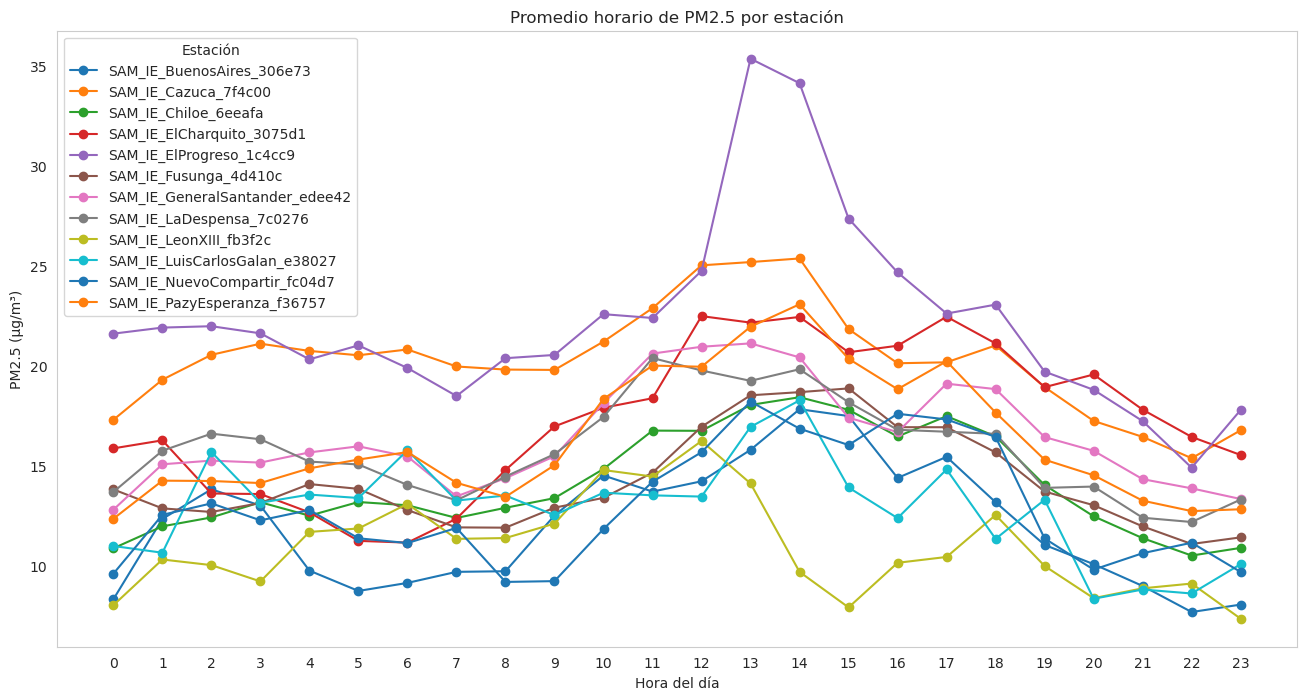

In [14]:
# Agrupar por estación y hora
pm25_hora_todas = df_moni.groupby(['Estación', 'hora'])['PM25'].mean().reset_index()

# Pivotear para gráfico tipo líneas por estación
pm25_hora_pivot = pm25_hora_todas.pivot(index='hora', columns='Estación', values='PM25')

# Graficar todas las estaciones
pm25_hora_pivot.plot(figsize=(16,8), marker='o')
plt.xlabel('Hora del día')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Promedio horario de PM2.5 por estación')
plt.grid()
plt.xticks(range(0,24))
plt.legend(title='Estación')
plt.show()

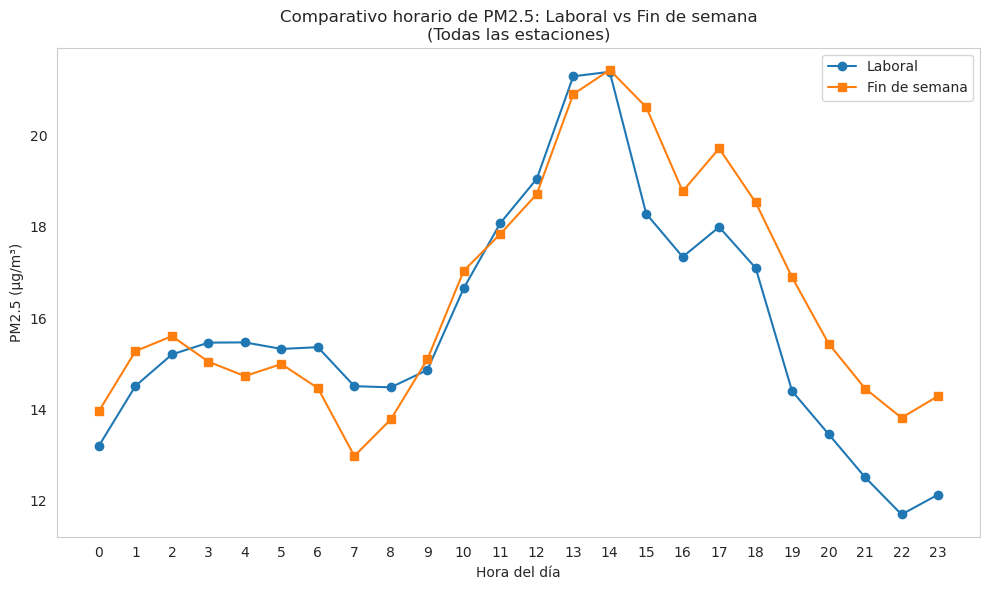

In [12]:
# =============================================================================
# 6. Análisis temporal global: promedio horario y comparación por tipo de día
# =============================================================================

# Agregar columna: día de la semana (0=lunes, 6=domingo)
df_moni['dia_semana'] = df_moni['date'].dt.dayofweek

# Crear columna 'tipo_dia': laboral (lunes a viernes) o fin de semana (sábado/domingo)
df_moni['tipo_dia'] = df_moni['dia_semana'].apply(lambda x: 'Fin de semana' if x >= 5 else 'Laboral')

# Calcular promedio horario de PM2.5 para días laborales
pm25_hora_laboral = df_moni[df_moni['tipo_dia'] == 'Laboral'].groupby('hora')['PM25'].mean().reset_index()

# Calcular promedio horario de PM2.5 para fines de semana
pm25_hora_finde = df_moni[df_moni['tipo_dia'] == 'Fin de semana'].groupby('hora')['PM25'].mean().reset_index()

# Graficar comparación de perfiles horarios
plt.figure(figsize=(10,6))
plt.plot(pm25_hora_laboral['hora'], pm25_hora_laboral['PM25'], marker='o', label='Laboral')
plt.plot(pm25_hora_finde['hora'], pm25_hora_finde['PM25'], marker='s', label='Fin de semana')
plt.xlabel('Hora del día')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Comparativo horario de PM2.5: Laboral vs Fin de semana\n(Todas las estaciones)')
plt.grid()
plt.legend()
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


## 7. Análisis y Visualización Horaria por Estación: Laboral vs Fin de Semana

Para cada estación de monitoreo, se compara el perfil horario de PM2.5 entre días laborales y fines de semana.  
Además, cada punto se **clasifica por color** según los niveles de la Resolución 2254 de 2017:

- **Verde:** Cumple norma (≤15 µg/m³)
- **Amarillo:** Nivel de observación (>15 y ≤25 µg/m³)
- **Naranja:** Riesgo moderado (>25 y ≤37 µg/m³)
- **Rojo intenso:** Supera el límite (>37 µg/m³)

### Códigos clave:

```python
def clasificar_pm25(valor):
    if valor <= 15:
        return "Verde"
    elif valor <= 25:
        return "Amarillo"
    elif valor <= 37:
        return "Naranja"
    else:
        return "Rojo intenso"


Para cada estación:

Se calcula el promedio horario de PM2.5 para días laborales y fines de semana.

Se asigna una categoría de color a cada valor promedio.

Se grafican los dos perfiles horarios en un solo gráfico, con puntos de colores y leyenda de la norma.

Interpretación:
Así se visualizan fácilmente los horarios y días donde la calidad del aire es más crítica y si alguna estación sobrepasa los valores normativos.


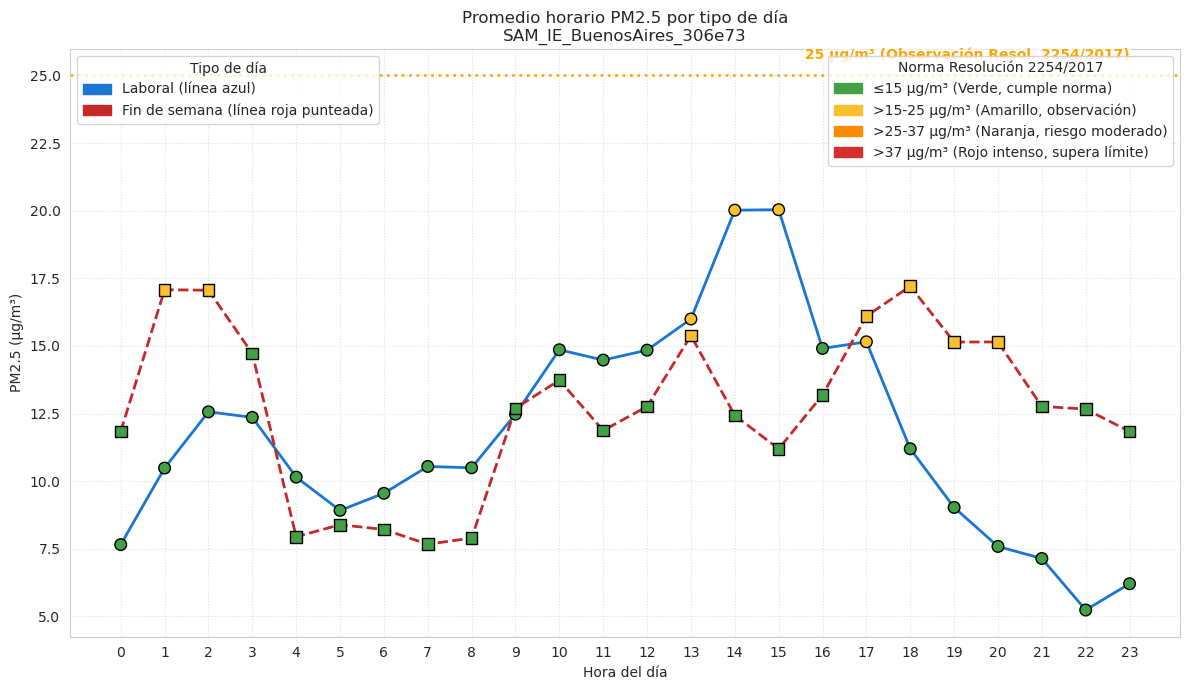

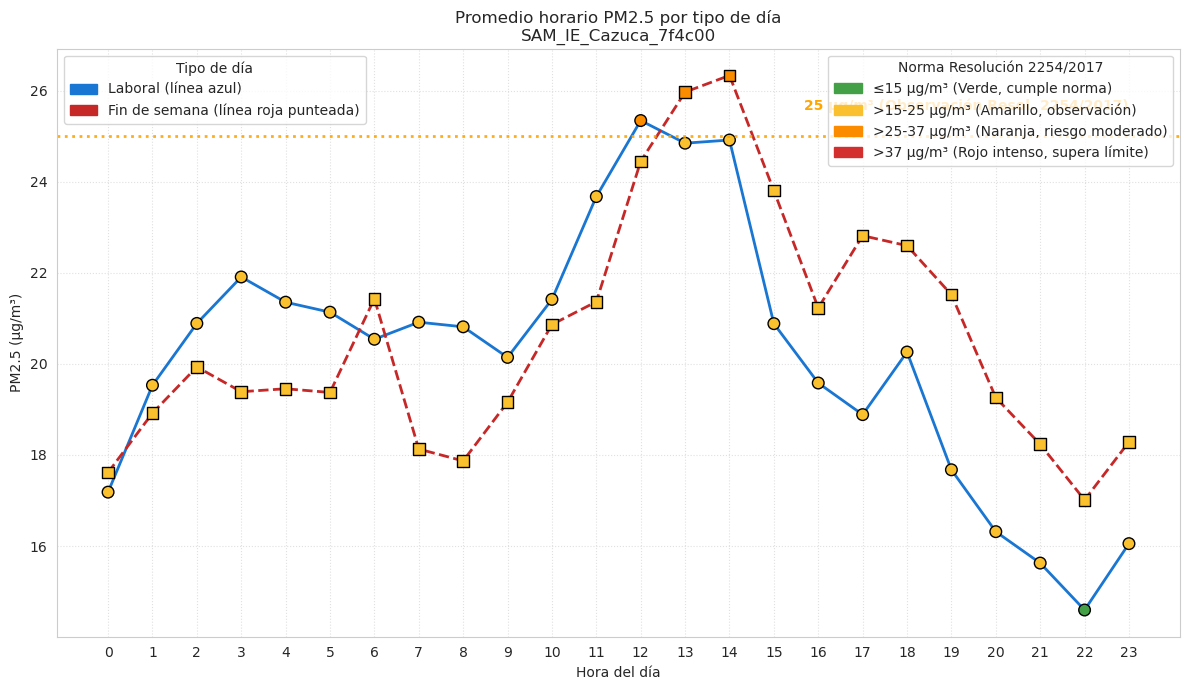

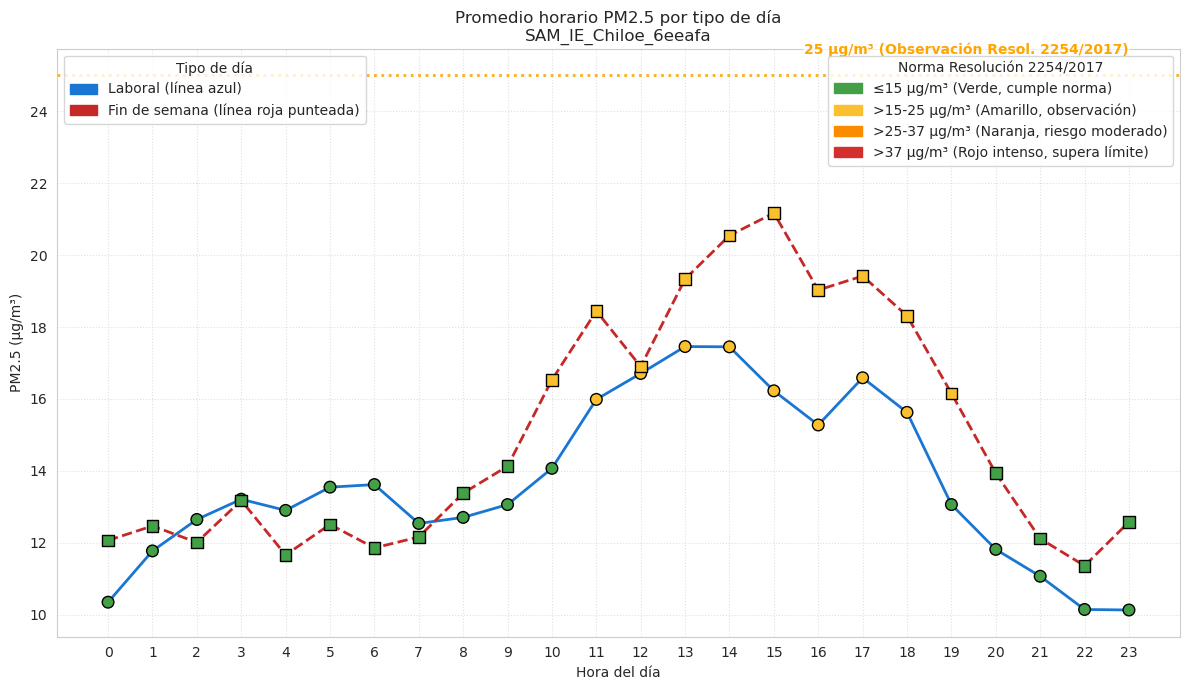

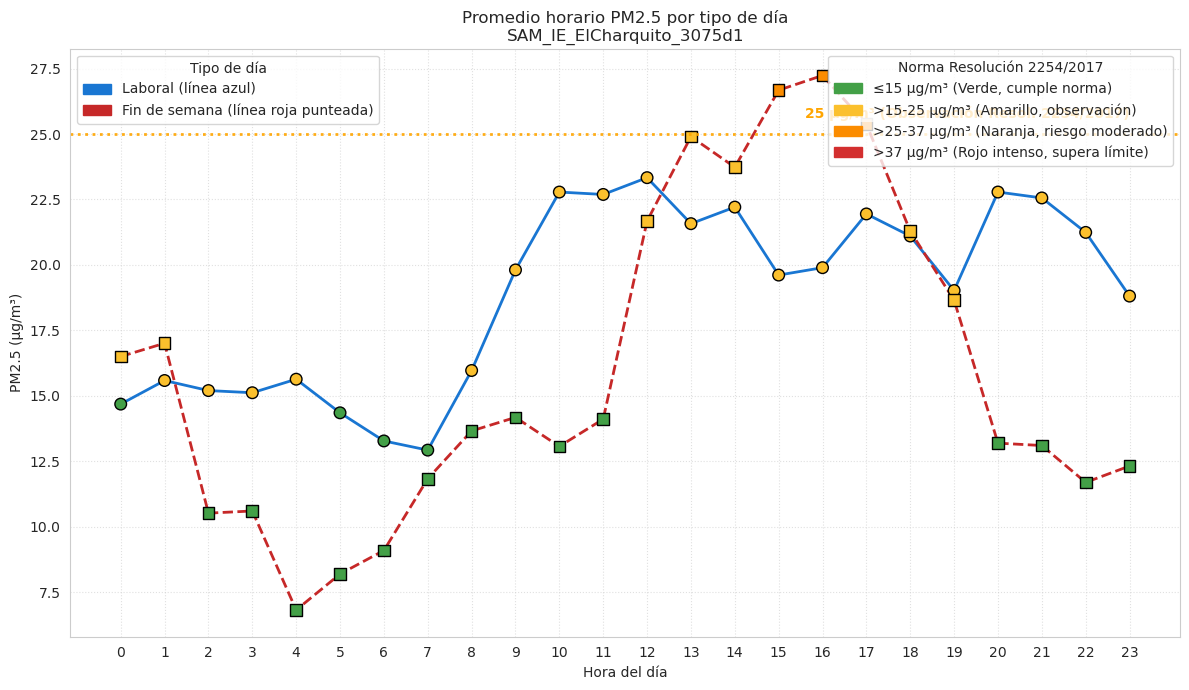

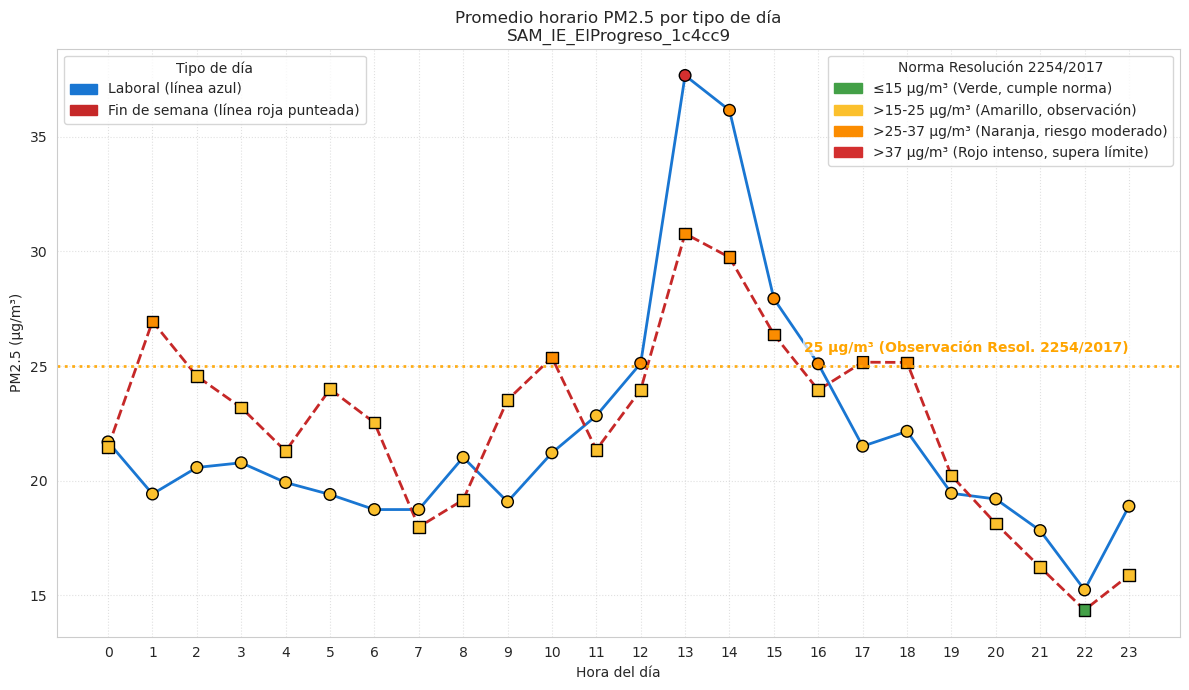

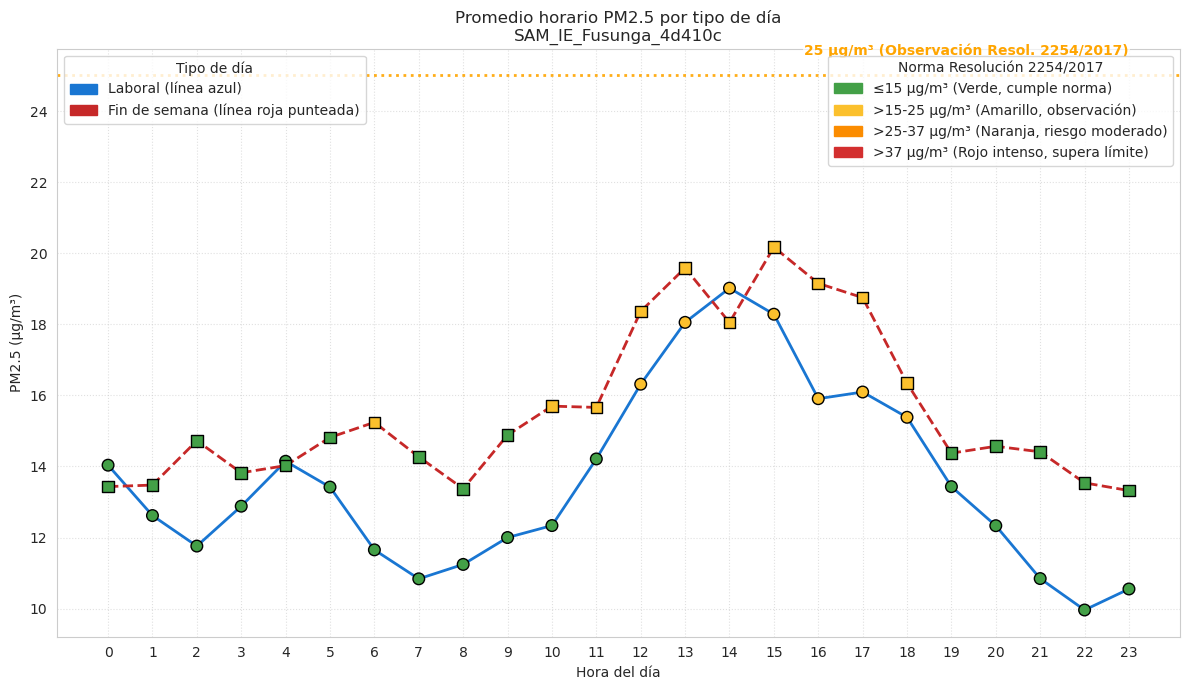

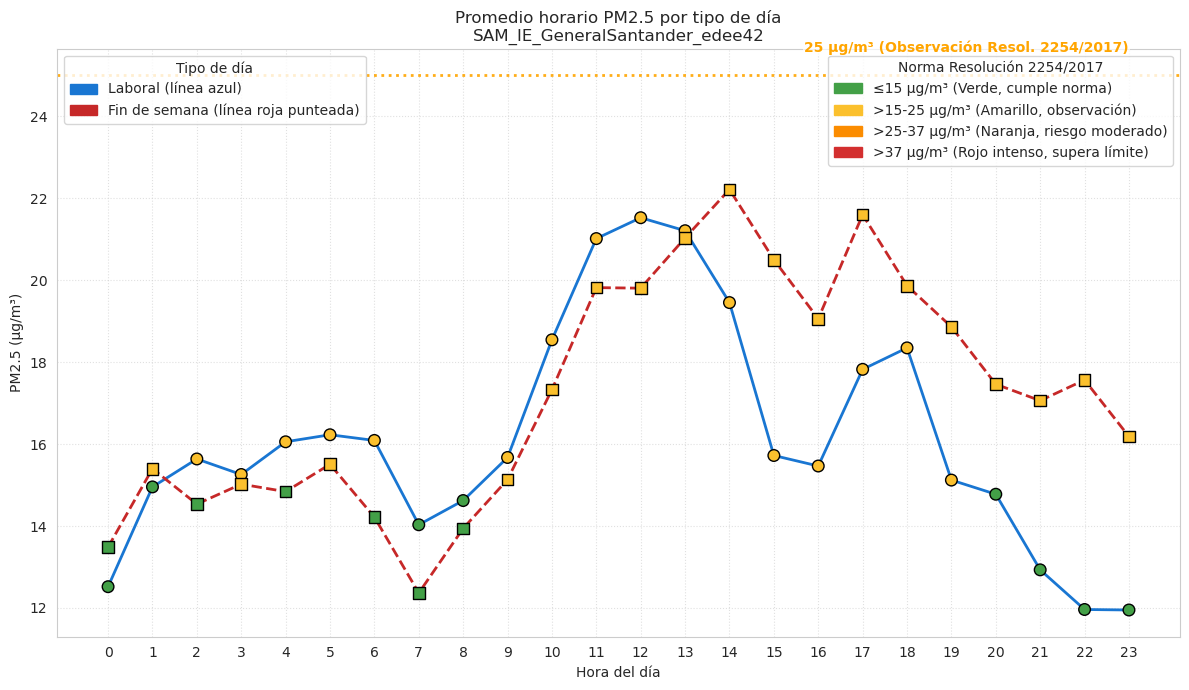

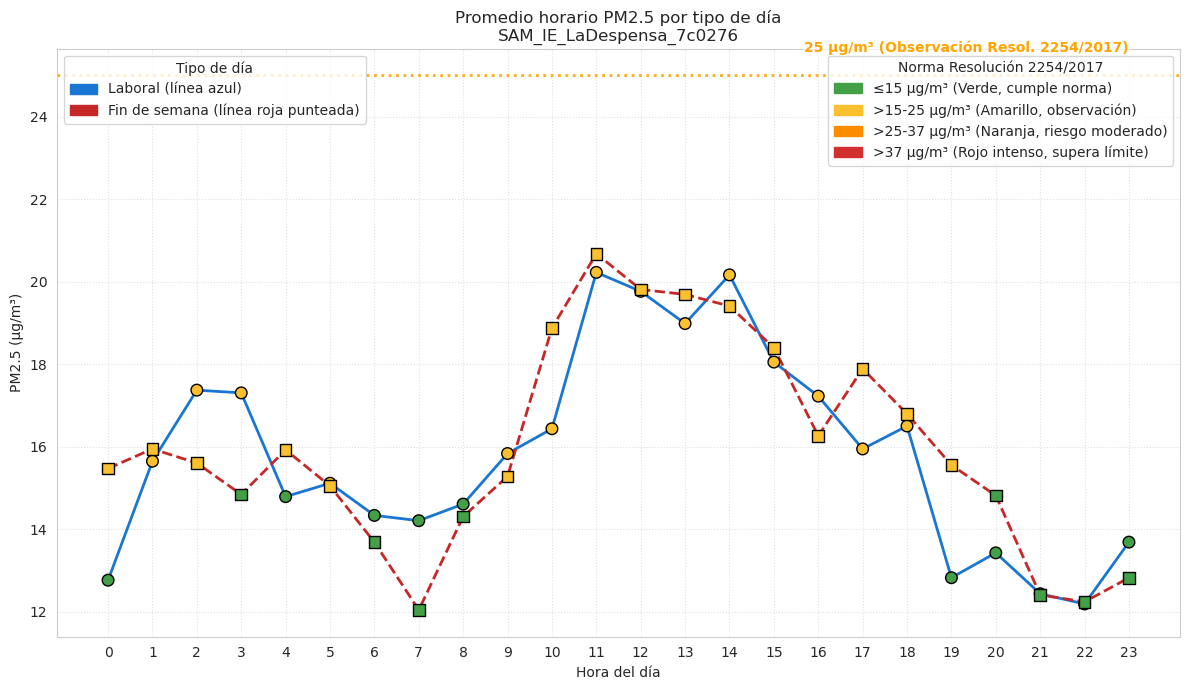

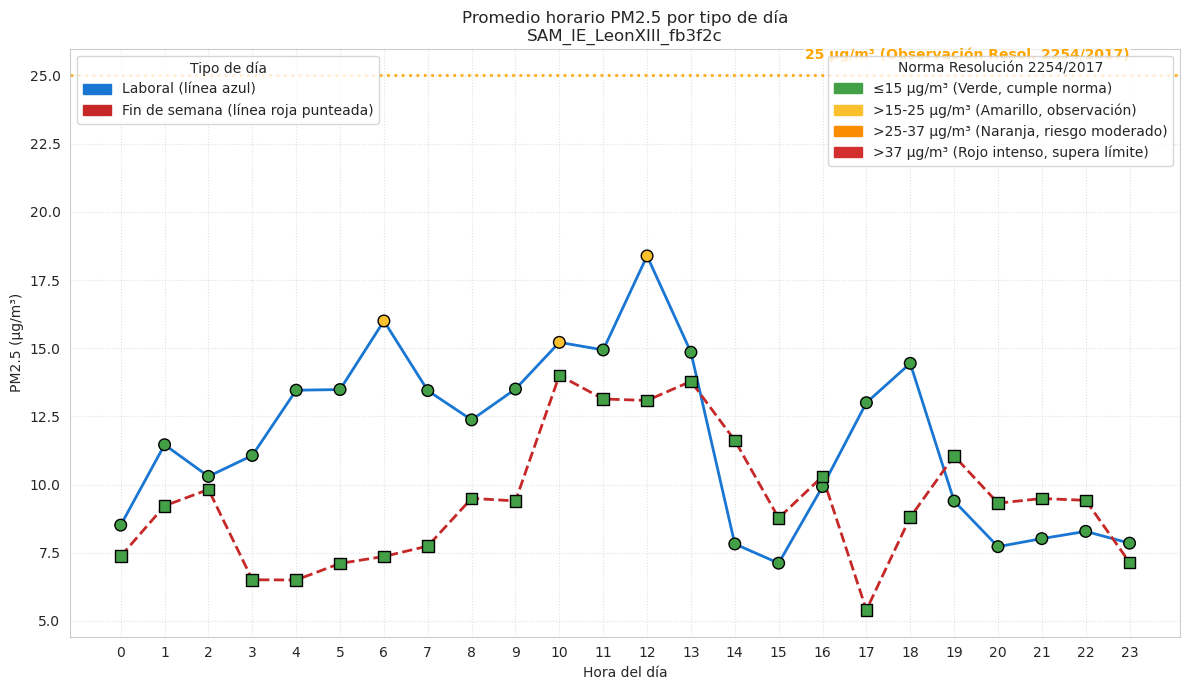

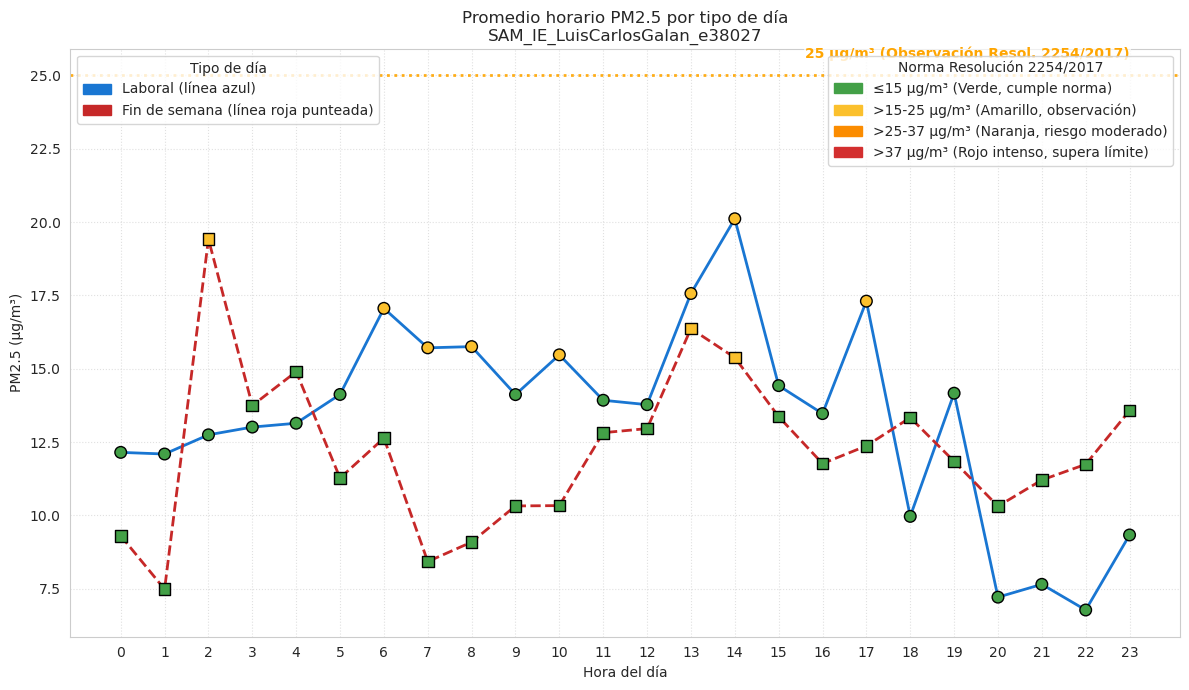

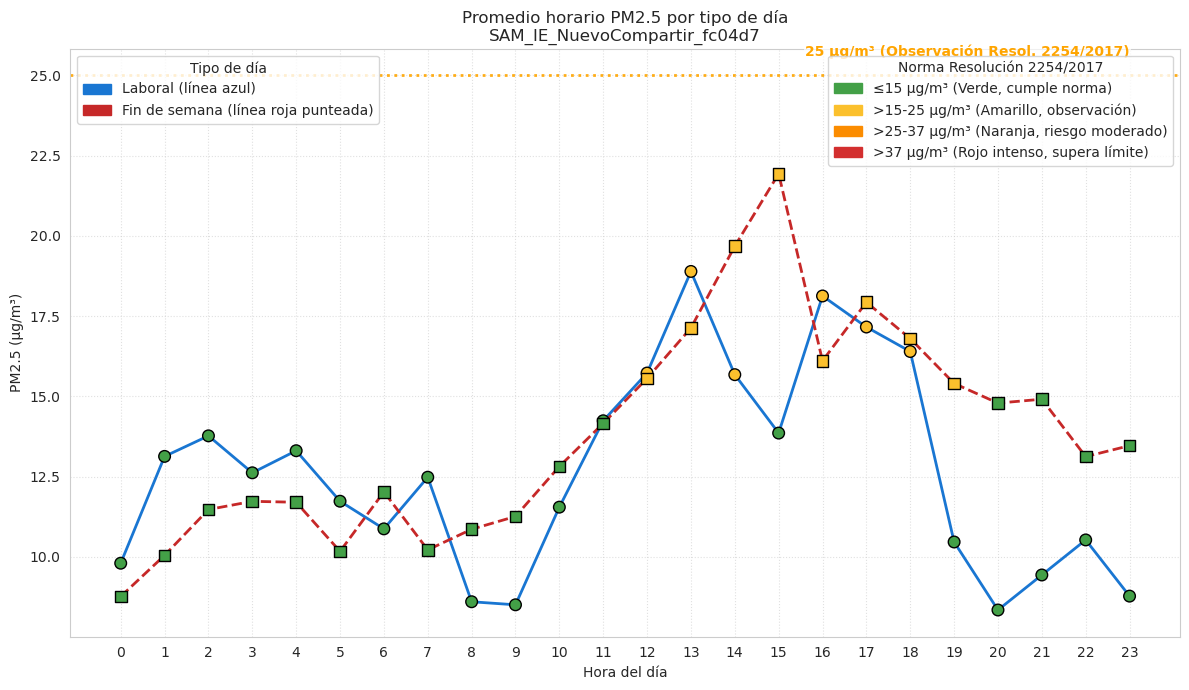

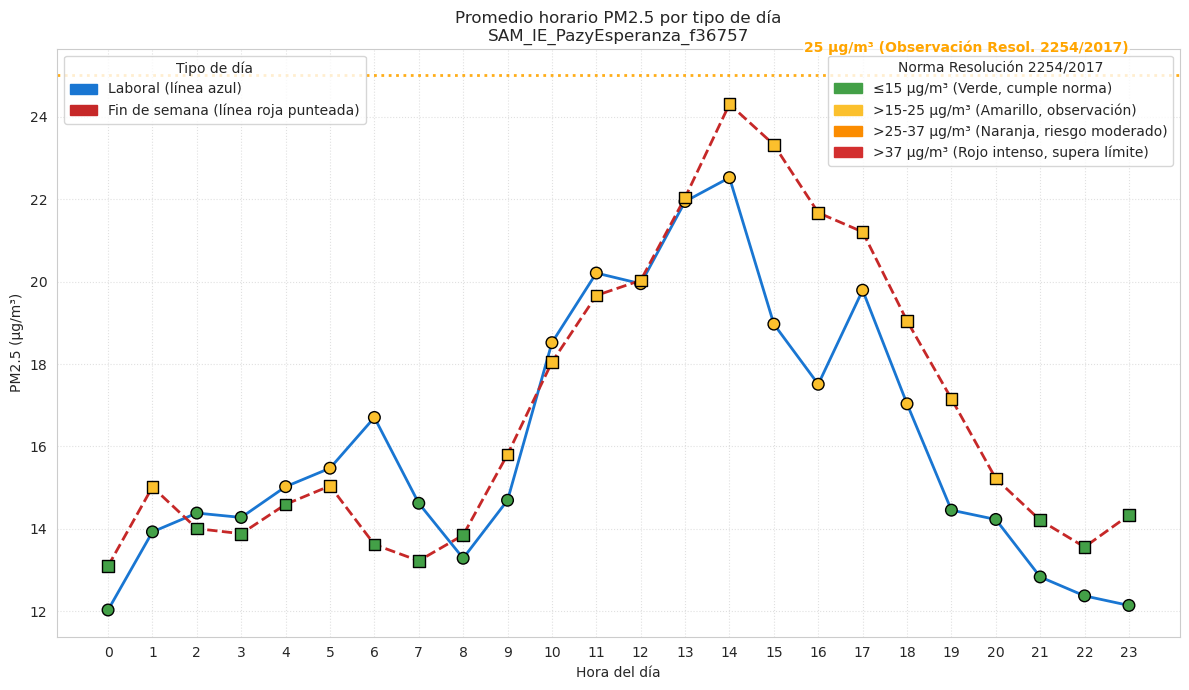

In [13]:
# =============================================================================
# 7. Análisis y visualización horaria por estación, con categorías de la norma
# =============================================================================

# Función para clasificar el PM2.5 según la Resolución 2254/2017
def clasificar_pm25(valor):
    if valor <= 15:
        return "Verde"
    elif valor <= 25:
        return "Amarillo"
    elif valor <= 37:
        return "Naranja"
    else:
        return "Rojo intenso"

color_map = {
    "Verde": "#43a047",
    "Amarillo": "#fbc02d",
    "Naranja": "#fb8c00",
    "Rojo intenso": "#d32f2f"
}

# Para cada estación, se genera el perfil horario por tipo de día y categoría
lista_estaciones = df_moni['Estación'].unique()

for nombre_estacion in lista_estaciones:
    df_est = df_moni[df_moni['Estación'] == nombre_estacion].copy()
    df_est['dia_semana'] = df_est['date'].dt.dayofweek
    df_est['tipo_dia'] = df_est['dia_semana'].apply(lambda x: 'Fin de semana' if x >= 5 else 'Laboral')
    
    # Laboral
    pm25_hora_laboral = df_est[df_est['tipo_dia'] == 'Laboral'].groupby('hora')['PM25'].mean().reset_index()
    pm25_hora_laboral['Categoria'] = pm25_hora_laboral['PM25'].apply(clasificar_pm25)
    pm25_hora_laboral['Color'] = pm25_hora_laboral['Categoria'].map(color_map)

    # Fin de semana
    pm25_hora_finde = df_est[df_est['tipo_dia'] == 'Fin de semana'].groupby('hora')['PM25'].mean().reset_index()
    pm25_hora_finde['Categoria'] = pm25_hora_finde['PM25'].apply(clasificar_pm25)
    pm25_hora_finde['Color'] = pm25_hora_finde['Categoria'].map(color_map)
    
    plt.figure(figsize=(12,7))
    # Línea y puntos para días laborales
    plt.plot(
        pm25_hora_laboral['hora'], pm25_hora_laboral['PM25'],
        color='#1976d2', label='Laboral', linewidth=2, zorder=1
    )
    plt.scatter(
        pm25_hora_laboral['hora'], pm25_hora_laboral['PM25'],
        c=pm25_hora_laboral['Color'], s=70, edgecolor='black', zorder=2
    )

    # Línea y puntos para fines de semana
    plt.plot(
        pm25_hora_finde['hora'], pm25_hora_finde['PM25'],
        color='#c62828', label='Fin de semana', linewidth=2, linestyle='--', zorder=1
    )
    plt.scatter(
        pm25_hora_finde['hora'], pm25_hora_finde['PM25'],
        c=pm25_hora_finde['Color'], marker='s', s=70, edgecolor='black', zorder=2
    )

    # Línea de referencia: 25 µg/m³ (nivel de observación según norma)
    plt.axhline(y=25, color='orange', linestyle=':', linewidth=2, alpha=0.9)
    plt.text(
        23, 25.5, '25 µg/m³ (Observación Resol. 2254/2017)',
        color='orange', fontsize=10, ha='right', va='bottom', weight='bold',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
    )

    plt.xlabel('Hora del día')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.title(f'Promedio horario PM2.5 por tipo de día\n{nombre_estacion}')
    plt.grid(True, linestyle='dotted', alpha=0.6)
    plt.xticks(range(0,24))

    # Leyenda para la norma (colores de puntos)
    import matplotlib.patches as mpatches
    norma_patches = [
        mpatches.Patch(color=color_map["Verde"], label='≤15 µg/m³ (Verde, cumple norma)'),
        mpatches.Patch(color=color_map["Amarillo"], label='>15-25 µg/m³ (Amarillo, observación)'),
        mpatches.Patch(color=color_map["Naranja"], label='>25-37 µg/m³ (Naranja, riesgo moderado)'),
        mpatches.Patch(color=color_map["Rojo intenso"], label='>37 µg/m³ (Rojo intenso, supera límite)')
    ]
    linea_laboral = mpatches.Patch(color='#1976d2', label='Laboral (línea azul)')
    linea_finde = mpatches.Patch(color='#c62828', label='Fin de semana (línea roja punteada)')

    first_legend = plt.legend(handles=[linea_laboral, linea_finde], loc='upper left', title='Tipo de día')
    second_legend = plt.legend(handles=norma_patches, loc='upper right', title='Norma Resolución 2254/2017', frameon=True)
    plt.gca().add_artist(first_legend)

    plt.tight_layout()
    plt.show()


### GIF animado de PM2.5 por interpolación IDW

Se crea una animación mostrando la distribución espacial horaria de PM2.5 mediante interpolación IDW,  
con fondo de uso de suelo, límites de comunas, y colores por categorías de la norma nacional:

- Verde: ≤15 µg/m³
- Amarillo: >15-25 µg/m³
- Naranja: >25-37 µg/m³
- Rojo intenso: >37 µg/m³

Se utiliza `ListedColormap` y `BoundaryNorm` para asignar colores exactos a cada rango normativo, y así visualizar zonas y horarios críticos.

El GIF resultante se llama **`idw_pm25_comunas.gif`**.


In [21]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from shapely.geometry import Point
from scipy.spatial import cKDTree
import os

# Leer shapes y reproyectar
gdf_suelo = gpd.read_file(SHAPE_SUELO).to_crs(epsg=9377)
gdf_comunas = gpd.read_file(SHAPE_COMUNAS).to_crs(epsg=9377)

# Suponemos que tienes gdf_est (con geometry epsg:9377) y df_moni con 'Estación', 'hora', 'PM25'

horas = range(0,24)  # puedes ajustar

# Grilla regular sobre Soacha
xmin, ymin, xmax, ymax = gdf_suelo.total_bounds
res = 150
xi = np.linspace(xmin, xmax, res)
yi = np.linspace(ymin, ymax, res)
xi, yi = np.meshgrid(xi, yi)
grid_points = np.c_[xi.ravel(), yi.ravel()]

def idw_interpolation(xy_obs, values, xy_grid, power=2):
    tree = cKDTree(xy_obs)
    dists, idxs = tree.query(xy_grid, k=len(xy_obs))
    dists[dists == 0] = 1e-12
    weights = 1 / dists ** power
    weights /= weights.sum(axis=1)[:,None]
    return (values[idxs] * weights).sum(axis=1)

# Colores y límites para la norma (Resolución 2254/2017)
from matplotlib.colors import ListedColormap, BoundaryNorm
color_list = ["#43a047", "#fbc02d", "#fb8c00", "#d32f2f"]
cmap = ListedColormap(color_list)
bounds = [0, 15, 25, 37, 200]  # Limites de categoría
norm = BoundaryNorm(bounds, cmap.N)

# Carpeta temporal
gif_folder = "gif_idw_frames"
os.makedirs(gif_folder, exist_ok=True)
filenames = []

for h in horas:
    # PM2.5 promedio por estación para la hora h
    df_hora = df_moni[df_moni['hora']==h].groupby('Estación')['PM25'].mean().reset_index()
    df_est_hora = gdf_est.merge(df_hora, on='Estación')
    xy_obs = np.array([(p.x, p.y) for p in df_est_hora.geometry])
    values = df_est_hora['PM25'].values

    # IDW
    grid_pm25 = idw_interpolation(xy_obs, values, grid_points).reshape(xi.shape)

    # Graficar
    fig, ax = plt.subplots(figsize=(10,10))
    gdf_suelo.plot(ax=ax, color="lightgrey", alpha=0.5, edgecolor='none')
    gdf_comunas.boundary.plot(ax=ax, color="black", linewidth=1)
    im = ax.imshow(
        grid_pm25, extent=(xmin, xmax, ymin, ymax), origin="lower",
        cmap=cmap, norm=norm, alpha=0.68
    )
    gdf_est.plot(ax=ax, color="blue", markersize=50, edgecolor="white", zorder=5)
    ax.set_title(f"Interpolación IDW PM2.5 - Hora {h:02d}:00", fontsize=16)
    ax.axis('off')

    # Leyenda manual de la norma
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color=color_list[0], label='≤15 µg/m³ (Verde)'),
        mpatches.Patch(color=color_list[1], label='>15-25 µg/m³ (Amarillo)'),
        mpatches.Patch(color=color_list[2], label='>25-37 µg/m³ (Naranja)'),
        mpatches.Patch(color=color_list[3], label='>37 µg/m³ (Rojo intenso)')
    ]
    ax.legend(handles=legend_patches, loc='lower right', frameon=True, fontsize=11, title="Norma PM2.5")

    fname = f"{gif_folder}/frame_{h:02d}.png"
    plt.savefig(fname, bbox_inches='tight', dpi=120)
    plt.close()
    filenames.append(fname)

# Crear GIF animado

with imageio.get_writer('idw_pm25_comunas.gif', mode='I', duration=5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
